# Kitchenware Classifier Using KFold Cross Validation

In [1]:
import gc
import os
import sys

from collections import defaultdict
from hashlib import md5

import numpy as np
import PIL
import seaborn as sns
import fastai
import torch

from fastai.vision.all import (
    set_seed,
    Path,
    pd,
    plt,
    aug_transforms,
    ImageDataLoaders,
    vision_learner,
    error_rate,
    accuracy,
    Resize,
    minimum,
    steep,
    valley,
    slide,
    SaveModelCallback,
    EarlyStoppingCallback,
    Interpretation,
    Learner,
    MixUp,
    cnn_learner,
    partial,
    DataBlock,
    ImageBlock,
    MultiCategoryBlock,
    ColReader,
    IndexSplitter,
    FlipItem,
    RandomErasing,
    Normalize,
)
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from torch import device

# import timm

print(os.listdir("../kitchenware_classifier/data/"))
print("Python       :", sys.version.split("\n")[0])
print("FastAI       :", fastai.__version__)
print("Numpy        :", np.__version__)
print("Torch        :", torch.__version__)
print("CUDA         :", torch.cuda.is_available())

%matplotlib inline

['sample_submission.csv', 'test.csv', 'models', 'train.csv', 'images', 'extra.csv']
Python       : 3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 15:55:03) 
FastAI       : 2.7.10
Numpy        : 1.22.4
Torch        : 1.13.1+cu117
CUDA         : True


## Load data and set variables

In [2]:
SEED = 42
set_seed(42)
BATCH_SIZE = 8
IMG_SIZE = 224

PROJECT_DIR = Path("../kitchenware_classifier")
DATA_DIR = PROJECT_DIR / "data"
IMG_DIR = DATA_DIR / "images"

TRAIN_DF = pd.read_csv(DATA_DIR / "train.csv")
TEST_DF = pd.read_csv(DATA_DIR / "test.csv")
EXTRA_DF = pd.read_csv(DATA_DIR / "extra.csv")
TRAIN_DF = pd.concat([TRAIN_DF, EXTRA_DF], ignore_index=True)

TRAIN_DF.rename(columns={"Id": "image"}, inplace=True)
TRAIN_DF["Id"] = TRAIN_DF.loc[:, "image"]

TEST_DF.rename(columns={"Id": "image"}, inplace=True)
TEST_DF["Id"] = TEST_DF.loc[:, "image"]

TRAIN_DF["image"] = TRAIN_DF["Id"].map(lambda x: f"{IMG_DIR.absolute()}/{x:0>4}.jpg")
TEST_DF["image"] = TEST_DF["Id"].map(lambda x: f"{IMG_DIR}/{x:0>4}.jpg")

In [3]:
display(TRAIN_DF.head())
display(TEST_DF.head())

,image,label,Id
0,/home/clamytoe/Projects/kitchenware_classifier/notebooks/../kitchenware_classifier/data/images/0560.jpg,glass,560
1,/home/clamytoe/Projects/kitchenware_classifier/notebooks/../kitchenware_classifier/data/images/4675.jpg,cup,4675
2,/home/clamytoe/Projects/kitchenware_classifier/notebooks/../kitchenware_classifier/data/images/0875.jpg,glass,875
3,/home/clamytoe/Projects/kitchenware_classifier/notebooks/../kitchenware_classifier/data/images/4436.jpg,spoon,4436
4,/home/clamytoe/Projects/kitchenware_classifier/notebooks/../kitchenware_classifier/data/images/8265.jpg,plate,8265


,image,Id
0,../kitchenware_classifier/data/images/0678.jpg,678
1,../kitchenware_classifier/data/images/3962.jpg,3962
2,../kitchenware_classifier/data/images/9271.jpg,9271
3,../kitchenware_classifier/data/images/5133.jpg,5133
4,../kitchenware_classifier/data/images/8842.jpg,8842


## EDA

In [4]:
TRAIN_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6875 entries, 0 to 6874
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   6875 non-null   object
 1   label   6875 non-null   object
 2   Id      6875 non-null   object
dtypes: object(3)
memory usage: 161.3+ KB


### Check the class distributions

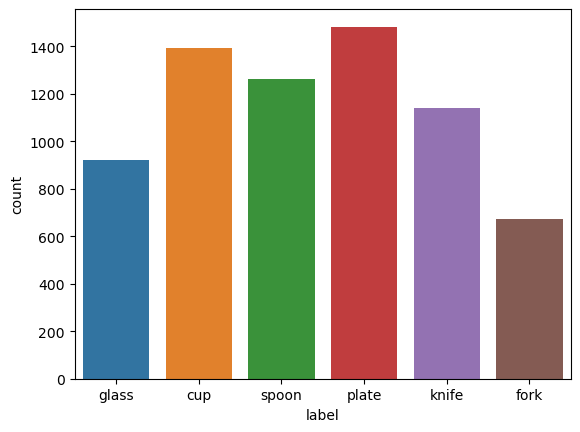

In [5]:
sns.countplot(data=TRAIN_DF, x="label")
plt.show()

### Check for duplicate images

In [6]:
hash_dict = defaultdict(list)
for image in IMG_DIR.glob("*.jpg"):
    with image.open("rb") as f:
        img_hash = md5(f.read()).hexdigest()
        hash_dict[img_hash].append(image)
len(hash_dict)

10677

In [7]:
duplicate_img = []
for k, v in hash_dict.items():
    if len(v) > 1:
        if v[0].name != v[1].name:
            duplicate_img.append(v[0])
            duplicate_img.append(v[1])
            print(v)
len(duplicate_img)

[Path('../kitchenware_classifier/data/images/7103.jpg'), Path('../kitchenware_classifier/data/images/5428.jpg')]
[Path('../kitchenware_classifier/data/images/4234.jpg'), Path('../kitchenware_classifier/data/images/0237.jpg')]
[Path('../kitchenware_classifier/data/images/4162.jpg'), Path('../kitchenware_classifier/data/images/3458.jpg')]
[Path('../kitchenware_classifier/data/images/8532.jpg'), Path('../kitchenware_classifier/data/images/6833.jpg')]
[Path('../kitchenware_classifier/data/images/7196.jpg'), Path('../kitchenware_classifier/data/images/7063.jpg')]
[Path('../kitchenware_classifier/data/images/6624.jpg'), Path('../kitchenware_classifier/data/images/7469.jpg')]


12

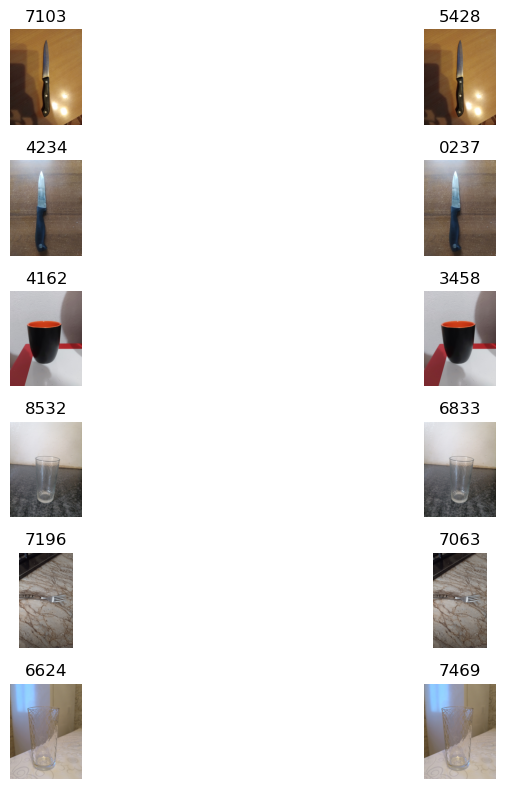

In [8]:
plt.figure(figsize=(12, 8))

for idx, img in enumerate(duplicate_img):
    im = PIL.Image.open(img)
    title = img.stem
    plt.subplot(6, 2, idx + 1)
    plt.imshow(im)
    plt.title(title)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [9]:
(len(duplicate_img) / len(hash_dict))

0.00112391121101433

> Since the amount of duplicate images are so insignificant, I'm not going to worry about them.

## KFold validation

I modified the code from this great article that I found on the subject: [fastai MultiLabel Classification using Kfold Cross Validation](https://medium.com/analytics-vidhya/fastai-multilabel-classification-using-kfold-cross-validation-706b5948e138)

In [10]:
strat_kfold = MultilabelStratifiedKFold(n_splits=3, random_state=42, shuffle=True)
stfold = strat_kfold.split(TRAIN_DF.image.values, TRAIN_DF.iloc[:, 1:].values)
TRAIN_DF["fold"] = -1
for i, (_, test_index) in enumerate(stfold):
    TRAIN_DF.iloc[test_index, -1] = i

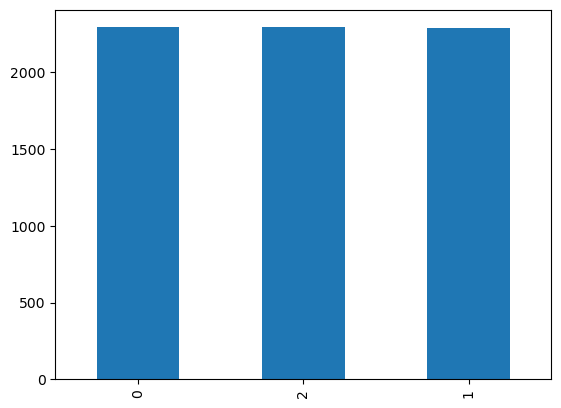

In [11]:
TRAIN_DF.fold.value_counts().plot.bar();

## Metrics

In [12]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid:
        inp = inp.sigmoid()
    return ((inp > thresh) == targ.bool()).float().mean()

In [13]:
def F_score(output, label, threshold=0.2, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)

    return F2.mean(0)

In [14]:
mixup = MixUp(0.3)

The original code from the article was causing my system to run out of memory, so I had to play around with the values in order to get it to run all of th way through. In the end, I eded up reducing the bactch sizes by quite a bit.

In [15]:
def get_data(fold=0, size=224, bs=16):
    blocks = (ImageBlock, MultiCategoryBlock)
    idx_splitter = IndexSplitter(TRAIN_DF[TRAIN_DF.fold == fold].index)
    xtrans = aug_transforms(
        size=size,
        do_flip=True,
        flip_vert=True,
        max_rotate=180.0,
        max_zoom=1.1,
        max_lighting=0.6,
        max_warp=0.2,
        p_affine=0.75,
        p_lighting=0.75,
        xtra_tfms=[
            RandomErasing(p=0.5, sh=0.1, min_aspect=0.2, max_count=2),
        ],
    )
    db = DataBlock(
        blocks=blocks,
        get_x=ColReader(0),                   # image paths
        get_y=ColReader(1, label_delim=" "),  # label
        splitter=idx_splitter,
        item_tfms=[FlipItem(p=0.5), Resize(512, method="pad")],
        batch_tfms=[*xtrans, Normalize],
    )

    return db.dataloaders(TRAIN_DF, bs=bs)

> **NOTE:** The `label_delim` is very important here. Originally I had removed it because it seemed like a way to split a string of texts into seperate classes, which is what it's used for. But without it. the actualy name of your class is split into individual letters! Not what I wanted!

The article wasn't saving the best model, so I decided to add that here, so that at then end, the best model would be loaded and used for the final predictions. 

I also decided to optimize the learning rate and it allowed me to improve my score on Kaggle to **0.97777**!

epoch,train_loss,valid_loss,accuracy_multi,F_score,time
0,0.742832,0.332222,0.567699,0.850564,00:47
1,0.448280,0.140894,0.899287,0.932870,00:48
2,0.262894,0.064578,0.978985,0.918298,00:49
3,0.211160,0.055536,0.977822,0.929846,00:49
4,0.200247,0.050648,0.982330,0.927354,00:49
5,0.191389,0.049232,0.980803,0.937275,00:49
6,0.175267,0.045705,0.981239,0.947857,00:49
7,0.179084,0.046314,0.982257,0.943277,00:49


No improvement since epoch 6: early stopping


lrs=SuggestedLRs(minimum=3.311311274956097e-07, steep=1.9054607491852948e-06, valley=0.0020892962347716093, slide=0.0030199517495930195)


epoch,train_loss,valid_loss,accuracy_multi,F_score,time
0,0.199999,0.052038,0.977094,0.938127,02:18


Better model found at epoch 0 with accuracy_multi value: 0.9770942330360413.


epoch,train_loss,valid_loss,accuracy_multi,F_score,time
0,0.187667,0.043779,0.982984,0.934983,06:08
1,0.168828,0.040531,0.983203,0.950143,06:09
2,0.173600,0.041492,0.982403,0.958544,06:07


Better model found at epoch 0 with accuracy_multi value: 0.9829843044281006.
Better model found at epoch 1 with accuracy_multi value: 0.9832028746604919.
No improvement since epoch 1: early stopping


epoch,train_loss,valid_loss,accuracy_multi,F_score,time
0,0.749024,0.362973,0.512804,0.823005,00:49
1,0.459727,0.127862,0.911392,0.939230,00:49
2,0.268197,0.059542,0.978466,0.923698,00:49
3,0.210407,0.054505,0.979194,0.927755,00:49
4,0.198752,0.046700,0.982686,0.942269,00:49
5,0.187547,0.045462,0.980794,0.947401,00:49
6,0.175918,0.045117,0.981885,0.941614,00:49
7,0.171502,0.044164,0.981595,0.945109,00:49
8,0.175151,0.043920,0.982322,0.946418,00:49
9,0.173692,0.043385,0.982395,0.947838,00:49


lrs=SuggestedLRs(minimum=7.585775847473997e-08, steep=9.12010818865383e-07, valley=0.0004786300996784121, slide=0.0020892962347716093)


epoch,train_loss,valid_loss,accuracy_multi,F_score,time
0,0.179669,0.053725,0.979631,0.929821,02:19


Better model found at epoch 0 with accuracy_multi value: 0.9796305894851685.


epoch,train_loss,valid_loss,accuracy_multi,F_score,time
0,0.188371,0.048567,0.979267,0.940504,06:07
1,0.184169,0.047059,0.981595,0.945106,06:07
2,0.173576,0.045270,0.982322,0.949471,06:07
3,0.166856,0.042848,0.983122,0.951099,06:07
4,0.171654,0.043523,0.984359,0.947614,06:08


Better model found at epoch 0 with accuracy_multi value: 0.9792668223381042.
Better model found at epoch 1 with accuracy_multi value: 0.9815947413444519.
Better model found at epoch 2 with accuracy_multi value: 0.9823222160339355.
Better model found at epoch 3 with accuracy_multi value: 0.9831223487854004.
Better model found at epoch 4 with accuracy_multi value: 0.9843591451644897.
No improvement since epoch 3: early stopping


epoch,train_loss,valid_loss,accuracy_multi,F_score,time
0,0.757520,0.312974,0.583115,0.850809,00:48
1,0.467646,0.124635,0.916667,0.933606,00:50
2,0.276081,0.057282,0.976222,0.936824,00:49
3,0.222573,0.049406,0.977894,0.938693,00:49
4,0.204121,0.049408,0.981748,0.939351,00:49


No improvement since epoch 3: early stopping


lrs=SuggestedLRs(minimum=6.309573450380412e-08, steep=2.2908675418875646e-06, valley=0.0010000000474974513, slide=0.001737800776027143)


epoch,train_loss,valid_loss,accuracy_multi,F_score,time
0,0.203241,0.054311,0.978330,0.938666,02:18


Better model found at epoch 0 with accuracy_multi value: 0.9783303737640381.


epoch,train_loss,valid_loss,accuracy_multi,F_score,time
0,0.193026,0.046385,0.984366,0.944583,06:06
1,0.178738,0.041551,0.985602,0.946335,06:06
2,0.179688,0.040350,0.986257,0.955712,06:06
3,0.168384,0.040447,0.984802,0.957893,06:06


Better model found at epoch 0 with accuracy_multi value: 0.9843660593032837.
Better model found at epoch 1 with accuracy_multi value: 0.9856023192405701.
Better model found at epoch 2 with accuracy_multi value: 0.9862567782402039.
No improvement since epoch 2: early stopping


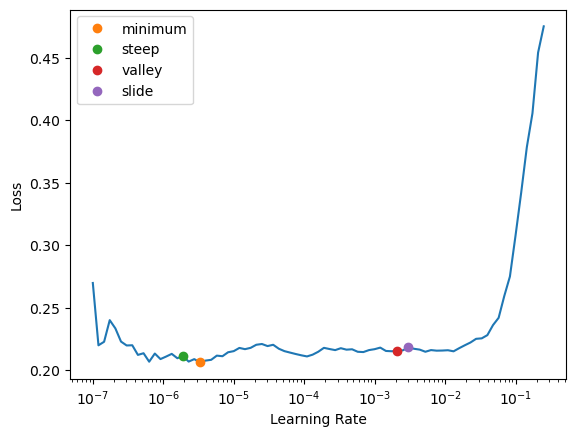

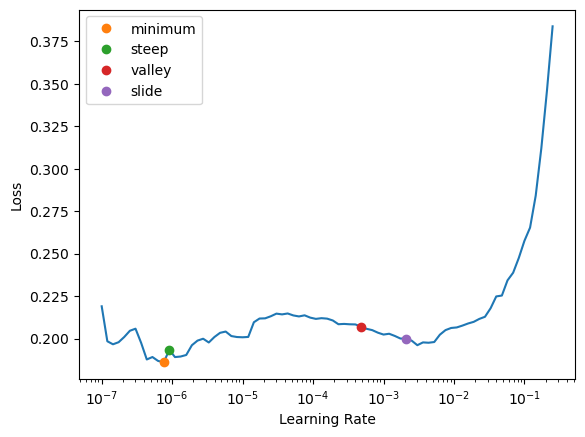

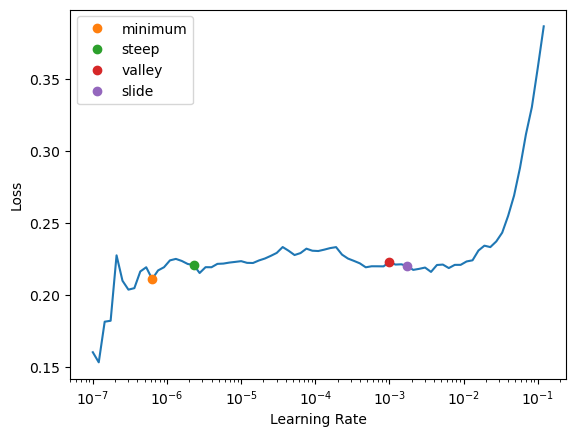

In [16]:
all_preds = []

for i in range(3):
    dls = get_data(i, 256, 32)
    learn = vision_learner(
        dls,
        "convnext_nano",
        metrics=[
            partial(accuracy_multi, thresh=0.2),
            partial(F_score, threshold=0.2),
        ],
        cbs=mixup,
    )  # .to_fp16()

    learn.fit_one_cycle(10, cbs=EarlyStoppingCallback(monitor="valid_loss"))
    learn.dls = get_data(i, 512, 16)

    lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
    print(f"{lrs=}")

    learn.fine_tune(10, lrs.valley, cbs=[
        EarlyStoppingCallback(monitor="valid_loss"),
        SaveModelCallback(
            monitor="accuracy_multi",
            min_delta=0.0001,
            fname="best-cv_model",
        ),
    ])
    m = f"{i}-best.pkl"
    learn.export(m)
    tst_dl = learn.dls.test_dl(TEST_DF)
    preds, _ = learn.get_preds(dl=tst_dl)
    all_preds.append(preds)

    # free up memory
    del learn
    torch.cuda.empty_cache()
    gc.collect()

Unlike the article, we are not trying to classify multiple objects in a single image, so I am not using the threshold variable. Instead I'm taking the class with the highest prediction.

In [17]:
preds = np.mean(np.stack(all_preds), axis=0)

k = dls.vocab
preds[0]
labelled_preds = [
    " ".join([k[i] for i, p in enumerate(pred) if p == max(pred)]) for pred in preds
]
TEST_DF["label"] = labelled_preds
TEST_DF.drop(['image'], axis=1, inplace=True)
TEST_DF.to_csv("submission.csv", index=False)

In [18]:
!head -n 10 submission.csv

Id,label
678,spoon
3962,knife
9271,fork
5133,plate
8842,fork
8256,fork
4622,spoon
2775,fork
5900,knife
